In [7]:

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
# loop over different anisotropy coefficients
d = 0
out = []
images = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # create a mesh of cardiomyocytes (elems = 1):
    tissue.mesh = np.ones([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    # add fibers orientation vectors
    tissue.fibers = np.zeros([2, n, n,])
    tissue.fibers[0] = np.cos(alpha)
    tissue.fibers[1] = np.sin(alpha)
    # add numeric method stencil for weights computations
    tissue.stencil = fw.AsymmetricStencil2D()
    tissue.D_al = 1
    tissue.D_ac = tissue.D_al/9

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.001
    aliev_panfilov.dr = 0.1
    aliev_panfilov.t_max = 12
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                n//2 - 5, n//2 + 5))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = (aliev_panfilov.u > 0.5).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images.append(aliev_panfilov.u.copy())

    out.append(pd.DataFrame(props))

out = pd.concat(out)

Running AlievPanfilov2D:   0%|          | 0/12000 [00:00<?, ?it/s]

Running AlievPanfilov2D: 100%|██████████| 12000/12000 [00:21<00:00, 565.72it/s]


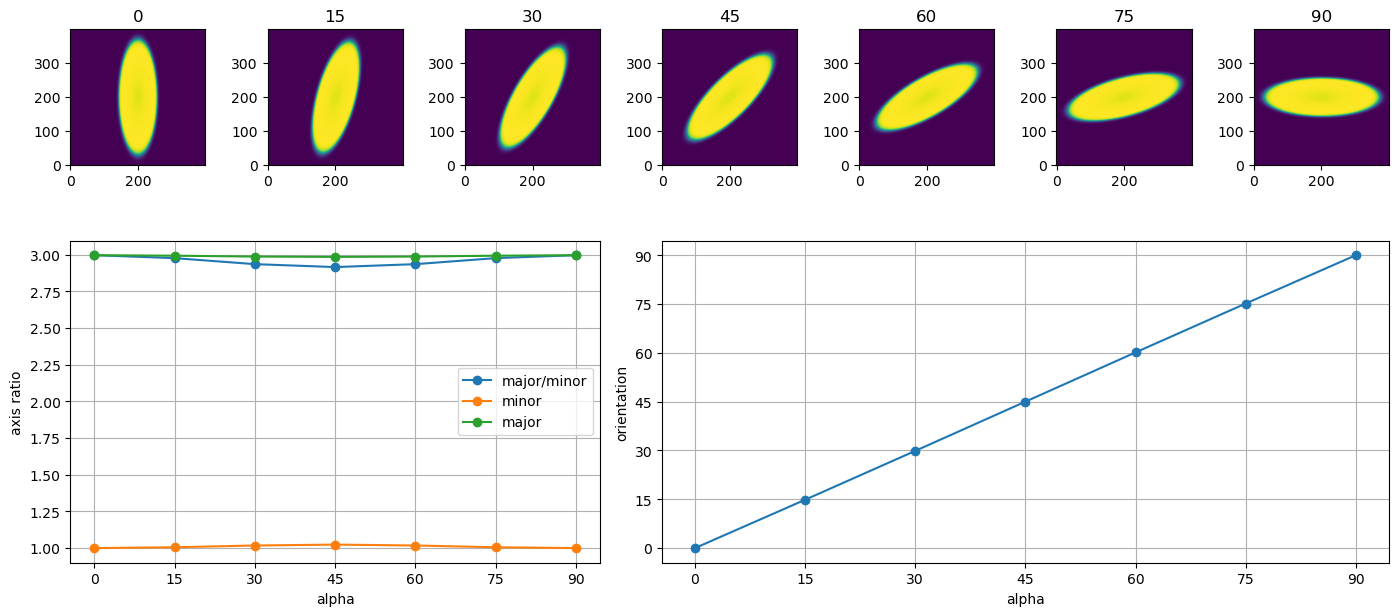

In [8]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 3 + ['orientation']*4],
                               figsize=(14, 7))

for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images[i], cmap='viridis', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

ax = axs['axis_ratio']
ax.plot(out['alpha'], out['axis_ratio'], 'o-', label='major/minor')
ax.plot(out['alpha'], out['minor_axis_length'] / out['minor_axis_length'].min(), 'o-', label='minor')
ax.plot(out['alpha'], out['major_axis_length'] / out['minor_axis_length'].min(), 'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

ax = axs['orientation']
ax.plot(out['alpha'], out['orientation'], 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
# loop over different anisotropy coefficients
d = 0.2
out_10 = []
images_10 = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # create a mesh of cardiomyocytes (elems = 1):
    tissue.mesh = np.ones([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    # add fibers orientation vectors
    tissue.fibers = np.zeros([2, n, n])
    tissue.fibers[0] = np.cos(alpha)
    tissue.fibers[1] = np.sin(alpha)
    # add numeric method stencil for weights computations
    tissue.stencil = fw.AsymmetricStencil2D()
    tissue.D_al = 1
    tissue.D_ac = tissue.D_al/9

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.001
    aliev_panfilov.dr = 0.1
    aliev_panfilov.t_max = 20
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                 n//2 - 5, n//2 + 5))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = (aliev_panfilov.u > 0.5).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images_10.append(aliev_panfilov.u.copy())

    out_10.append(pd.DataFrame(props))

out_10 = pd.concat(out_10)

Running AlievPanfilov2D:   0%|          | 0/20000 [00:00<?, ?it/s]

Running AlievPanfilov2D: 100%|██████████| 20000/20000 [00:33<00:00, 595.99it/s]


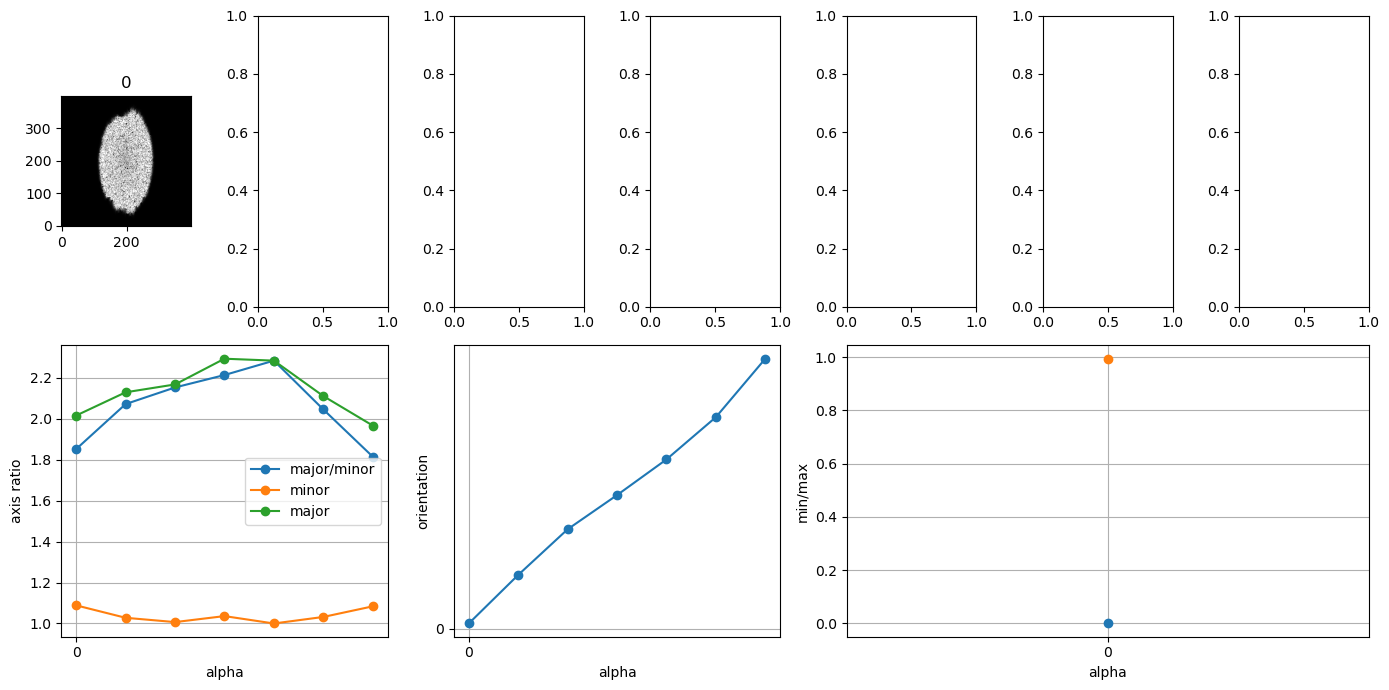

In [16]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 2 + ['orientation']*2 +
                               ['min_max'] * 3],
                               figsize=(14, 7))

mins = []
maxs = []
for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images_10[i], cmap='gray', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

    mins.append(images_10[i].min())
    maxs.append(images_10[i].max())
    

ax = axs['axis_ratio']
ax.plot(out_10['alpha'], out_10['axis_ratio'], 'o-', label='major/minor')
ax.plot(out_10['alpha'], out_10['minor_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='minor')
ax.plot(out_10['alpha'], out_10['major_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

out_10.loc[out_10['orientation'] < 0, 'orientation'] += 180

orientation = out_10['orientation'].values
orientation[orientation > 90] = 180 - orientation[orientation > 90]

ax = axs['orientation']
ax.plot(out_10['alpha'], orientation, 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

ax = axs['min_max']
ax.plot(np.degrees(alphas), mins, 'o-', label='min')
ax.plot(np.degrees(alphas), maxs, 'o-', label='max')
ax.set_xlabel('alpha')
ax.set_ylabel('min/max')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

#### TP06 model

In [14]:

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400
d = 0
alphas = np.radians(np.arange(0, 91, 15))[:1]

tp06_props = []
tp06_images = []

for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    tissue.mesh = np.ones([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    tissue.fibers = np.zeros([2, n, n,])
    tissue.fibers[0] = np.cos(alpha)
    tissue.fibers[1] = np.sin(alpha)

    tissue.stencil = fw.AsymmetricStencil2D()
    tissue.D_al = 0.154
    tissue.D_ac = tissue.D_al/9

    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 20, n//2 - 5, n//2 + 5,
                                                n//2 - 5, n//2 + 5))

    model = fw.TP062D()
    model.dt = 0.001
    model.dr = 0.1
    model.t_max = 10
    model.cardiac_tissue = tissue
    model.stim_sequence = stim_sequence

    model.run()

    labeled = (model.u > -40).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    tp06_images.append(model.u.copy())

    tp06_props.append(pd.DataFrame(props))

tp06_props = pd.concat(tp06_props)

Running TP062D: 100%|██████████| 10000/10000 [03:15<00:00, 51.27it/s]
